#Construct Ba forcing sets (regions + point sources)

In [53]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime, datetime2datenum 

In [54]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
% matplotlib inline

# Selection of runoff

In [55]:
runoff_name=glob.glob('_data/NEMO/ORCA2_INPUT/runoff*.nc')
runoff_obj=nc.Dataset(runoff_name[0])
runoff=runoff_obj.variables['sorunoff'][:]
runoff_obj.variables['sorunoff'].units

u'kg/m2/s'

# Create spacial data

In [56]:
id_Ba = scipy.io.loadmat('_data/Exchange/Ba_classif.mat')
rf_Ba_group = id_Ba['rf_Ba_group'][:]
nav_lat = id_Ba['nav_lat'][:]
nav_lon = id_Ba['nav_lon'][:]

In [57]:
id_river = scipy.io.loadmat('_data/Exchange/River_Ba_nemo.mat')
Ob_season = id_river['Ob_Ba_nemo'][:][0]
Yenisey_season = id_river['Yenisey_Ba_nemo'][:][0]
Lena_season = id_river['Lena_Ba_nemo'][:][0]
Kolyma_season = id_river['Kolyma_Ba_nemo'][:][0]
Mackenzie_season = id_river['Mackenzie_Ba_nemo'][:][0]

In [58]:
Ba_ORCA2_2deg = np.zeros([12, 149, 182])

In [59]:
np.max(Ba_ORCA2_2deg)

0.0

In [60]:
for i in range(12):
    temp = Ba_ORCA2_2deg[i, :, :]
    temp[rf_Ba_group==1] = Ob_season[i]
    temp[rf_Ba_group==1.5] = Yenisey_season[i]
    temp[rf_Ba_group==2] = Lena_season[i]
    temp[rf_Ba_group==3] = Kolyma_season[i]
    temp[rf_Ba_group==4] = Mackenzie_season[i]
    Ba_ORCA2_2deg[i, :, :] = temp*runoff[i, :, :]/1025

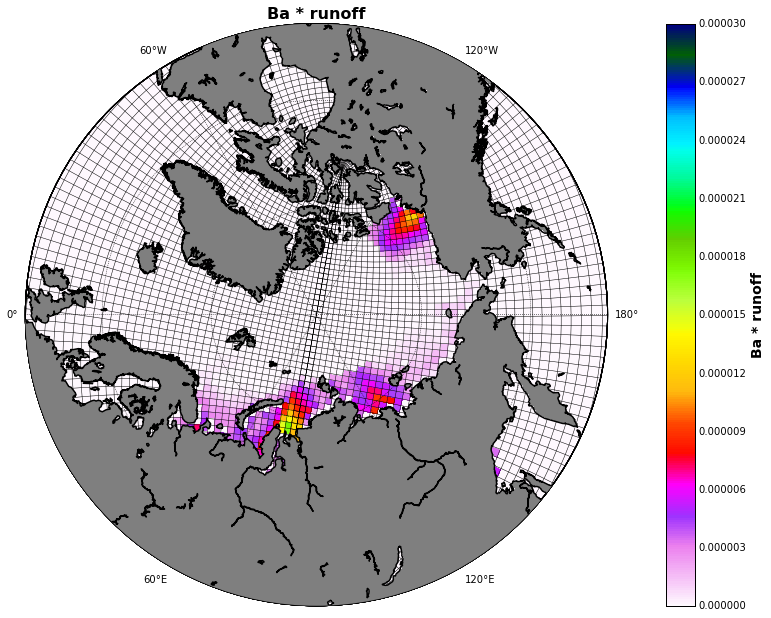

In [61]:
CMap=plt.cm.gist_ncar_r
var_name='Ba * runoff'
#
fig, ax, proj = Nts.pcolor_Arctic(nav_lon, nav_lat, 50, np.mean(Ba_ORCA2_2deg, 0), [0, 3e-5], CMap, var_name)
#
x, y = proj(nav_lon, nav_lat)
proj.plot(x.T, y.T, color='k', linewidth=0.5)
proj.plot(x, y, color='k', linewidth=0.5)
title='Ba * runoff'
ax.set_title(title, fontsize=16, fontweight='bold')
fig.set_size_inches(12, 12)
fig.canvas.draw()

In [22]:
save_var = {'nav_lon': nav_lon, 'nav_lat': nav_lat, 'Ba_ORCA2_2deg': Ba_ORCA2_2deg}
scipy.io.savemat('_data/Exchange/Ba_ORCA2_2deg.mat', mdict=save_var)

# Create spacial data (point source)

In [62]:
river_name = ['Pechora', 'Ob + Pur', 'Yenisey', 'Olenek', 'Yana', 'Indigirka', 'Kolyma', 'Mackenzie', \
              'Sev. Dvina', 'Lena', 'Khatanga', 'Taimyra', 'Pyasina']
lons = np.array([52, 66, 88, 123, 136, 148, 159, -135, 42, 127, 103, 100, 88])
lats = np.array([67, 67, 70, 72, 71, 70, 69, 68, 65, 73, 72, 76, 72])

In [63]:
from scipy.spatial import cKDTree

def do_kdtree(nav_lon, nav_lat, lons, lats):
    #
    combined_x_y_arrays = np.dstack([nav_lon.ravel(), nav_lat.ravel()])[0]
    points_list = list(np.array([lons.T, lats.T]).T)
    #
    mytree = cKDTree(combined_x_y_arrays)
    dist, index_flat = mytree.query(points_list)
    x, y = np.unravel_index(index_flat, nav_lon.shape)
    return x, y

In [64]:
x_index, y_index = do_kdtree(nav_lon, nav_lat, lons, lats)

In [65]:
addoffsets = [[0,-2], [1, -5], [3-1, 6-1], [1, 4], [2, 0], [2, 3], [1, 1], [+2, -2], [2, -2], [0, 1], [-2, +5], [-2, +4], [-1, 6]]
x_index_fixed = np.empty(np.size(x_index))
y_index_fixed = np.empty(np.size(y_index))
for i in range(13):
    x_index_fixed[i] = x_index[i] + addoffsets[i][0]
    y_index_fixed[i] = y_index[i] + addoffsets[i][1]
x_index_fixed = x_index_fixed.astype(np.int)
y_index_fixed = y_index_fixed.astype(np.int)

# Add Ba source by modifying runoff file

12 monthes × 149 × 182

In [66]:
runoff.shape

(12L, 149L, 182L)

In [67]:
print(river_name)

['Pechora', 'Ob + Pur', 'Yenisey', 'Olenek', 'Yana', 'Indigirka', 'Kolyma', 'Mackenzie', 'Sev. Dvina', 'Lena', 'Khatanga', 'Taimyra', 'Pyasina']


In [68]:
Ba_ORCA2_2deg = np.zeros(runoff.shape)
Ba_ORCA2_2deg[np.isnan(runoff)]=np.nan
Ba_ORCA2_2deg[:, x_index_fixed[1], y_index_fixed[1]]=Ob_season*runoff[:, x_index_fixed[1], y_index_fixed[1]]/1025
Ba_ORCA2_2deg[:, x_index_fixed[2], y_index_fixed[2]]=Yenisey_season*runoff[:, x_index_fixed[2], y_index_fixed[2]]/1025
Ba_ORCA2_2deg[:, x_index_fixed[6], y_index_fixed[6]]=Kolyma_season*runoff[:, x_index_fixed[6], y_index_fixed[6]]/1025
Ba_ORCA2_2deg[:, x_index_fixed[7], y_index_fixed[7]]=Mackenzie_season*runoff[:, x_index_fixed[7], y_index_fixed[7]]/1025
Ba_ORCA2_2deg[:, x_index_fixed[9], y_index_fixed[9]]=Lena_season*runoff[:, x_index_fixed[9], y_index_fixed[9]]/1025

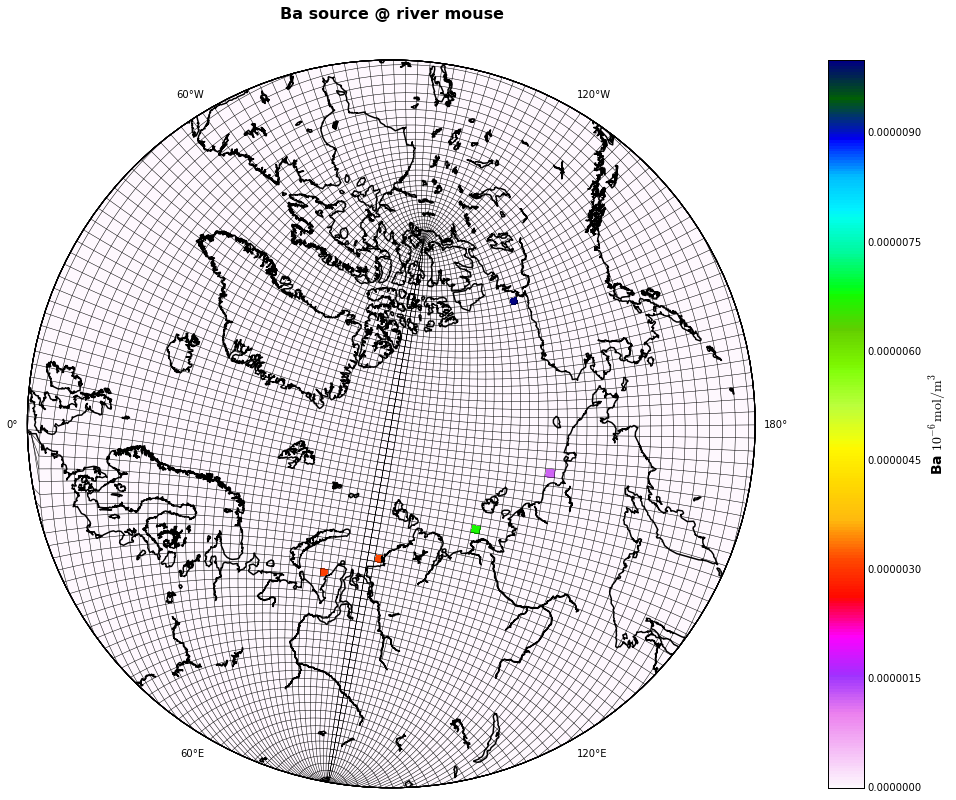

In [70]:
CMap=plt.cm.gist_ncar_r #cm.GMT_seis_r
var_name='Ba $\mathrm{10^{-6} mol/m^3}$'
Ba_id_interp_masked=np.ma.masked_where(np.isnan(Ba_ORCA2_2deg[7, :, :]), Ba_ORCA2_2deg[7, :, :])
#
fig, ax, proj = Nts.pcolor_Arctic(nav_lon, nav_lat, 50, Ba_id_interp_masked, [0, 1e-5], CMap, var_name, hit=0)
#
title="Ba source @ river mouse"
ax.set_title(title, fontsize=16, fontweight='bold', y=1.05)
fig.set_size_inches(15, 15)
#
x, y=proj(nav_lon, nav_lat)
proj.plot(x.T, y.T, color='k', linewidth=0.5)
proj.plot(x, y, color='k', linewidth=0.5)
fig.canvas.draw()

# Save data

In [71]:
save_var = {'nav_lon': nav_lon, 'nav_lat': nav_lat, 'Ba_ORCA2_2deg': Ba_ORCA2_2deg}
scipy.io.savemat('_data/Exchange/Ba_ORCA2_2deg.mat', mdict=save_var)

In [72]:
glob.glob('_data/Exchange/Ba_ORCA2_2deg.mat')

['_data/Exchange/Ba_ORCA2_2deg.mat']